In [1]:
from dotenv import load_dotenv, find_dotenv
import os
import openai

# Cargar las variables de entorno desde el archivo .env
load_dotenv('/home/.env')

openai.api_key = os.environ['OPENAI_API_KEY']

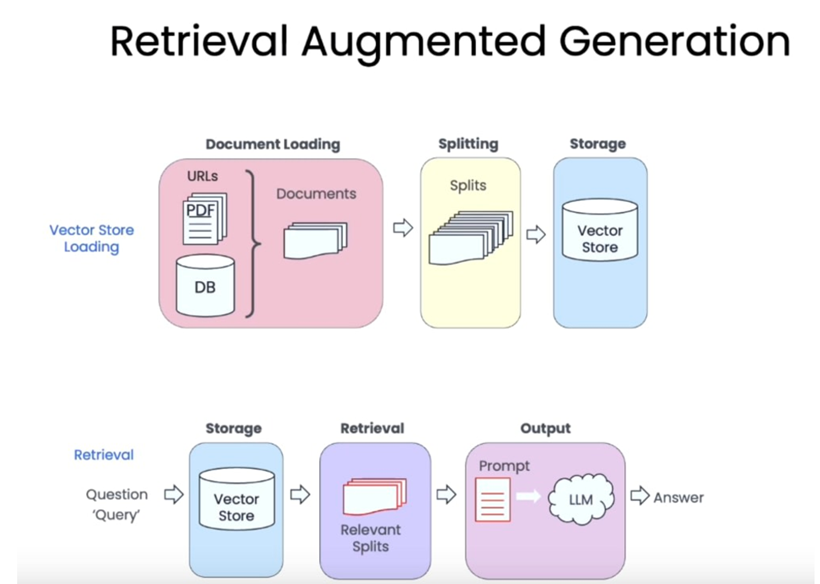

### Carga de datos

In [3]:
import json

# Ruta del archivo JSON
ruta_json = 'datos.json'

# Leer el archivo JSON
with open(ruta_json, 'r', encoding='utf-8') as archivo:
    data = json.load(archivo)

**Flujo general del código**
- Fragmentos de texto (almacenados en subdivisiones) se convierten en objetos Document.
- Los embeddings se generan utilizando el modelo de OpenAI.
- Los documentos y sus embeddings se almacenan en una base de datos Chroma persistente.

### Document Splitting

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

##### RecursiveCharacterTextSplitter esta recomendado para un documento generico

In [7]:
# Primera división por "Título"
r_splitter = RecursiveCharacterTextSplitter(
    chunk_overlap = 0,     # Superposición entre fragmentos establecida en 0. 
    separators=["Título"]  # Separador definido como "Título"
)

# Texto a dividir
texto_split = r_splitter.split_text(texto_unico)  # Se realiza la división del texto.


In [9]:
# Segunda división: subdividir cada fragmento, pero sin cortar los títulos
sub_splitter = CharacterTextSplitter(
    chunk_size    = 2000,  # Tamaño más pequeño para la subdivisión interna
    chunk_overlap = 250,
    separator=' '   # Separador más genérico
)

# Aplicar la segunda división a cada fragmento generado por la primera
subdivisiones = []
for fragmento in texto_split:
    # Puedes optar por no dividir fragmentos pequeños si no hace falta
    if len(fragmento) > 300:
        subdivisiones.extend(sub_splitter.split_text(fragmento))
    else:
        subdivisiones.append(fragmento)

# Vectorstores and Embeddings

In [42]:
# ! pip install chromadb

In [14]:
!rm -rf ./docs/chroma  # remove old database files if any

- Document: Clase de LangChain utilizada para encapsular fragmentos de texto (o cualquier contenido). Cada fragmento se convierte en un objeto Document, que puede incluir texto y metadatos.
  
- Chroma: Una base de datos vectorial que permite almacenar y buscar documentos basados en sus representaciones vectoriales.
  
- OpenAIEmbeddings: Una clase para generar embeddings (representaciones numéricas) de texto utilizando un modelo de OpenAI.
- Los embeddings son vectores que capturan características semánticas del texto, facilitando comparaciones y búsquedas basadas en similitud.



In [3]:
from langchain.docstore.document import Document
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings() # Genera embeddings a partir del texto utilizando modelos preentrenados de OpenAI.

persist_directory = 'docs/chroma/' # La base de datos Chroma almacenará los datos en el directorio especificado (docs/chroma/). 
                            # Esto permite que los datos estén disponibles incluso después de que el programa finalice.

# Convertir los fragmentos de texto en objetos Document
documentos = [Document(page_content=fragmento) for fragmento in subdivisiones] # Cada fragmento se encapsula en un objeto Document, que permite agregar metadatos si es necesario (aunque aquí no se especifican metadatos adicionales).


# Crear la base de datos vectorial Chroma desde los documentos

vectordb = Chroma.from_documents(  
    documents=documentos,
    embedding=embedding,
    persist_directory=persist_directory
)

# Entrada: Una lista de objetos Document y un modelo de embeddings (embedding).
# Funcionamiento:
# Genera embeddings para cada documento.
# Crea una base de datos vectorial que almacena los embeddings y los asocia con sus documentos originales.
# persist_directory: Especifica el lugar donde Chroma guardará los datos, permitiendo acceso persistente.

print(vectordb._collection.count()) # Muestra el número de documentos almacenados en la base de datos vectorial.

In [ ]:
# Guardamos la base para reutilizarla
vectordb.persist()

### Similarity Search | Retrieval-Augmented Generation (RAG)

In [21]:

docs = vectordb.similarity_search(question, k=5 # Definimos la cantidad de fragmentos a recuperar
           #                         filter={"source":"documento_especifico.pdf"} # Filtro para restingir en base a metadatos la recuperación
)


1. **`docs`**:  
   - Este es el nombre de la variable donde se almacenarán los resultados de la búsqueda de similitud. Se espera que `docs` sea una lista de documentos recuperados que sean similares a la consulta proporcionada.

2. **`vectordb.similarity_search`**:  
   - Este método realiza una búsqueda basada en similitudes en la base de datos vectorial. Compara la consulta (representada como un vector) con los vectores almacenados en la base de datos para encontrar los documentos más similares.

3. **`question`**:  
   - Representa la consulta del usuario. Es el texto o el vector con el que se buscan coincidencias en la base de datos. Puede ser una pregunta o cualquier cadena de texto relevante.

4. **`k=5`**:  
   - Especifica el número de documentos más similares que se desean recuperar. En este caso, se recuperarán los 5 documentos con mayor similitud. Ajustar este parámetro puede cambiar la cantidad de resultados devueltos.

5. **`filter`** (comentado en el código):  
   - Es un filtro opcional para limitar los documentos recuperados según criterios específicos. Por ejemplo:
     - `filter={"source": "documento_especifico.pdf"}` restringiría los resultados solo a aquellos documentos cuya fuente coincida con `"documento_especifico.pdf"`.
   - Los filtros son útiles para buscar similitudes dentro de un subconjunto de documentos.

In [2]:
# Visualizamos los fragmentos recuperados
for i in range(0, len(docs)):
    print(docs[i].page_content)
    print()

### Addressing Diversity: Maximum marginal relevance


In [ ]:
smalldb.max_marginal_relevance_search(question,k=2, fetch_k=3)  

1. **`smalldb.max_marginal_relevance_search`**:  
   - Es un método que realiza una búsqueda optimizada en una base de datos pequeña (o una base de datos específica llamada `smalldb`), utilizando el criterio de **Max Marginal Relevance (MMR)**.
   - El MMR equilibra la similitud de los documentos recuperados con la consulta (`question`) y la diversidad entre los documentos seleccionados. Esto ayuda a evitar resultados redundantes y a obtener un conjunto más variado de documentos relevantes.

2. **`question`**:  
   - Representa la consulta del usuario. Es el texto o vector que se utiliza como punto de referencia para buscar en la base de datos.

3. **`k=2`**:  
   - Define el número de resultados finales que se quieren recuperar. En este caso, se devolverán los 2 documentos más relevantes, balanceando similitud y diversidad.

4. **`fetch_k=3`**:  
   - Indica cuántos documentos iniciales se deben recuperar antes de aplicar el algoritmo MMR para seleccionar los mejores resultados. Aquí, la búsqueda preliminar recuperará 3 documentos, y luego se aplicará MMR para elegir los 2 más relevantes y diversos (debido al parámetro `k=2`).


- **Diversidad vs. Similitud**:  
  Este método es útil cuando se quiere evitar que los resultados sean demasiado similares entre sí, proporcionando un rango más amplio de información relevante.
 


# Consulta 

### Recuparamos la base de datos vectorial antes creada y guardada

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

persist_directory = 'docs/chroma/'

embedding = OpenAIEmbeddings()

vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)


### Creación de la cadena de preguntas, recuperación y generación de respuestas
####  ¿Para qué sirve?
- **Búsqueda de conocimiento:** Proporciona respuestas basadas en fuentes específicas, como bases de datos o documentos.
- **Chatbots avanzados:** Ideal para chatbots que necesitan responder preguntas basadas en información confiable.
- **Aplicaciones personalizadas:** Útil en contextos empresariales, legales, educativos, o herramienta poderosa para resolver consultas basadas en documentos específicos.

### **1. Configuración del modelo de lenguaje (LLM)**
```python
from langchain.chat_models import ChatOpenAI

llm_name = ['gpt-4o-mini', "gpt-4o"][-1]
llm = ChatOpenAI(model_name=llm_name, temperature=0)
```

#### **a. ChatOpenAI**
- Importa la clase `ChatOpenAI`, que permite trabajar con los modelos de lenguaje de OpenAI en el contexto de LangChain.

#### **b. Selección del modelo**
- **`llm_name`**: Se selecciona el último elemento de la lista `['gpt-4o-mini', "gpt-4o"]`, que en este caso es `"gpt-4o"`. Esto especifica qué modelo de OpenAI utilizar.
- **Por qué es importante:** Permite elegir entre diferentes modelos según sus capacidades y costos.

#### **c. Configuración del modelo**
- **`temperature=0`**: Se establece una temperatura baja, lo que hace que las respuestas sean más deterministas y consistentes (menos aleatorias).


In [ ]:
#!pip install -U langchain-openai

In [ ]:
from langchain.chat_models import ChatOpenAI

llm_name = ['gpt-4o-mini', "gpt-4o"][-1]

llm = ChatOpenAI(model_name=llm_name, temperature=0)


### **2. Creación de la cadena de preguntas y respuestas (`RetrievalQA`)**
```python
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)
```

#### **a. RetrievalQA**
- Es una cadena especializada de LangChain que combina:
  1. **Recuperación (Retrieval):** Recupera documentos relevantes desde una base de datos (en este caso, `vectordb`).
  2. **Generación (QA):** Usa un modelo de lenguaje (LLM) para responder preguntas basadas en los documentos recuperados.

#### **b. Método `from_chain_type`**
- Este método configura automáticamente una cadena `RetrievalQA` a partir de:
  - **`llm`**: El modelo de lenguaje seleccionado previamente.
  - **`retriever=vectordb.as_retriever()`**: El mecanismo para recuperar documentos relevante.
- **`as_retriever()`**: Convierte la base de datos vectorial en un componente de recuperación para buscar documentos relevante.

In [ ]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

1. **Pregunta del usuario:** El usuario proporciona una consulta.
2. **Búsqueda de documentos relevantes:**
   - La consulta se convierte en un vector.
   - Se utiliza `vectordb` para encontrar los documentos más similares.
3. **Generación de respuesta:** El modelo de lenguaje utiliza los documentos para generar la respuesta"**

In [ ]:
question  = "que es el sobreajuste"

In [ ]:
result = qa_chain({"query": question})
print(result['result'])

# PromptTemplate




### **Sección: Creación del PromptTemplate**

```python
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)
```

1. **`PromptTemplate.from_template(template)`**:
   - Crea un objeto `PromptTemplate` utilizando la plantilla definida anteriormente. Este objeto estructura cómo el modelo de lenguaje recibirá la entrada durante la ejecución.

2. **`QA_CHAIN_PROMPT`**:
   - Es el prompt que se utilizará para configurar la interacción en la cadena de preguntas y respuestas (QA chain).


2. **Marcadores de posición `{context}` y `{question}`**:
   - **`{context}`**: Lugar donde se insertará el contenido del contexto relevante para la respuesta.
   - **`{question}`**: Lugar donde se insertará la pregunta del usuario.
   

### **Observaciones Generales**
- **Modularidad**:  
  - El uso de plantillas y cadenas configurables permite personalizar fácilmente el comportamiento del sistema.
- **Claridad y Control**:  
  - El prompt está bien diseñado para limitar el modelo a responder exclusivamente con base en el contexto, evitando agregar información inventada o irrelevante.
- **Valor Agregado**:  
  - Las sugerencias de temas relacionados enriquecen la experiencia del usuario, ayudándolo a explorar más sobre el tema.
- **Rendimiento y Verificabilidad**:  
  - La devolución de los documentos fuente (`return_source_documents=True`) es esencial para garantizar la precisión y verificabilidad de las respuestas.


In [ ]:
# Build prompt
template = """Responde estrictamente basándote en la información proporcionada en el siguiente contexto.Proporcione una respuesta útil y clara a la pregunta planteada, asegurándose de cerrar con la frase: 
'¿Puedo ayudarte con algo más?'. 
Además, sugiera temas relacionados que puedan ser de interés para el usuario basándose en el contexto proporcionado. 
Asegúrese de que la respuesta sea precisa, relevante y mantenga un tono amigable y profesional. 
{context}
Question: {question}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}

# Map_reduce

El flujo de trabajo `map_reduce` se divide en dos etapas principales:

1. **`Map` (Dividir)**:
   - El contexto relevante se divide en partes más pequeñas (por ejemplo, fragmentos de texto, documentos individuales, etc.).
   - Cada parte se procesa por separado utilizando el modelo (`llm`) para generar respuestas individuales a partir de cada fragmento.
   - **Ventaja**: Esta etapa permite manejar de manera eficiente grandes cantidades de texto, evitando que el modelo se vea limitado por el tamaño máximo de tokens.

2. **`Reduce` (Combinar)**:
   - Las respuestas individuales generadas en la etapa `map` se combinan para formar una única respuesta coherente y consolidada.
   - El modelo puede agregar, resumir o seleccionar las partes más relevantes de las respuestas para construir la salida final.
   - **Ventaja**: Mejora la calidad de las respuestas al consolidar información de múltiples fuentes.

### **Ventajas del Enfoque `map_reduce`**
- **Escalabilidad**: Permite procesar grandes volúmenes de texto que no cabrían en la ventana de contexto del modelo.
- **Calidad de Respuesta**: Combina información de varias fuentes, lo que aumenta la probabilidad de generar una respuesta precisa y completa.
- **Flexibilidad**: Funciona bien con bases de datos grandes o fragmentadas.



In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)
result = qa_chain_mr({"query": question})
result["result"]

# Refine
### **Flujo de Trabajo:**

El enfoque `refine` se divide en dos etapas principales:

1. **Respuesta Inicial**:
   - El modelo genera una primera respuesta basada en un fragmento inicial del contexto recuperado por el `retriever`.
   - Esta respuesta sirve como un punto de partida para el refinamiento.

2. **Refinamiento Iterativo**:
   - El modelo procesa los siguientes fragmentos del contexto, uno por uno, refinando la respuesta inicial en cada paso.
   - En cada iteración, el modelo tiene acceso tanto a:
     - La respuesta generada hasta el momento.
     - El nuevo fragmento de contexto.
   - **Ventaja**: Este enfoque permite al modelo integrar nueva información en el contexto progresivamente, asegurando que la respuesta final sea coherente, completa y precisa.

### **Ventajas del Enfoque `refine`**
- **Integración Progresiva**: Permite construir respuestas que incorporan múltiples fragmentos de contexto de manera coherente.
- **Adaptabilidad**: Es ideal cuando el contexto relevante es grande o complejo, ya que el modelo no necesita procesarlo todo de una vez.
- **Mejoramiento Iterativo**: Garantiza que la respuesta final sea más rica y completa que una respuesta generada en una sola pasada.


### **Consideraciones**
- **Latencia**: Dado que el modelo realiza múltiples pasos para refinar la respuesta, este enfoque puede ser más lento que otros (como `stuff` o `map_reduce`).
- **Relevancia del Contexto**: El rendimiento del flujo depende de la calidad de los documentos recuperados. Si el `retriever` no selecciona información relevante, la respuesta podría ser menos precisa.
- **Uso de Tokens**: Este enfoque puede consumir más tokens en comparación con otros métodos, especialmente si el contexto contiene múltiples fragmentos grandes.

### **Comparación con `map_reduce`**
- **`map_reduce`** se centra en dividir y combinar, lo que genera respuestas independientes para cada fragmento y luego las sintetiza.
- **`refine`** toma un enfoque iterativo y acumulativo, refinando una respuesta única a medida que incorpora información adicional.

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="refine"
)
result = qa_chain_mr({"query": question})
result["result"]